In [33]:
# Imports
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
zip_path = 'dataset.zip'

In [3]:
# Extract data into a local folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

In [36]:
# List all CSV files in the data directory
csv_files = [f for f in os.listdir('data') if f.endswith('.csv')]
csv_files

['2019-Dec.csv',
 '2019-Nov.csv',
 '2019-Oct.csv',
 '2020-Feb.csv',
 '2020-Jan.csv']

In [10]:
for file in csv_files:
    df = pd.read_csv(os.path.join('data', file))
    df_list.append(df)

In [11]:
combined_df = pd.concat(df_list, ignore_index=True)

In [12]:
combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [13]:
combined_df.info()
combined_df.describe(include='all')
combined_df['event_type'].value_counts()
combined_df['category_code'].value_counts(dropna=False)
combined_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


event_time              0
event_type              0
product_id              0
category_id             0
category_code    20339246
brand             8757117
price                   0
user_id                 0
user_session         4598
dtype: int64

In [23]:
combined_df['event_time'] = pd.to_datetime(combined_df['event_time'])

In [16]:
# Get unique users by event stage
views = combined_df[combined_df['event_type'] == 'view']['user_id'].nunique()
carts = combined_df[combined_df['event_type'] == 'cart']['user_id'].nunique()
purchases = combined_df[combined_df['event_type'] == 'purchase']['user_id'].nunique()

In [17]:
# Create behavioral funnel using unique users
funnel = pd.DataFrame({
    'Stage': ['View', 'Cart', 'Purchase'],
    'Users': [views, carts, purchases]
})

funnel['Dropoff %'] = funnel['Users'].pct_change().fillna(0).abs().round(2) * 100
funnel

,Stage,Users,Dropoff %
0,View,1597754,0.0
1,Cart,398308,75.0
2,Purchase,110518,72.0


C:\Users\navin\AppData\Local\Temp\ipykernel_16420\2762306292.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funnel, x='Stage', y='Users', palette='Blues_d')


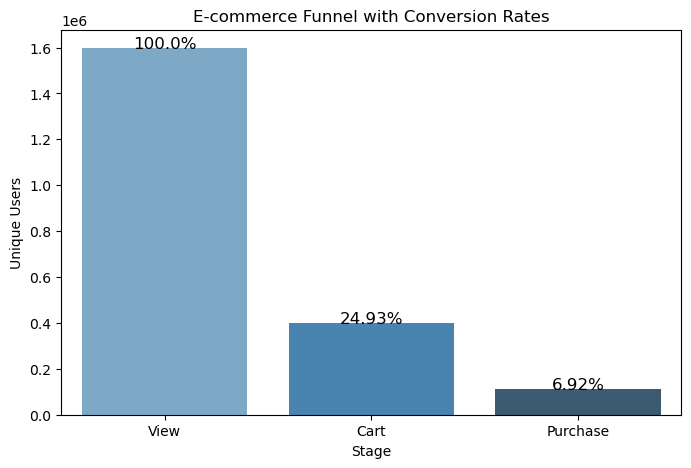

In [43]:
# Add conversion % to funnel dataframe
funnel['Conversion Rate (%)'] = (funnel['Users'] / funnel.loc[0, 'Users'] * 100).round(2)

# Visualize funnel with bar chart (including annotations)
plt.figure(figsize=(8,5))
sns.barplot(data=funnel, x='Stage', y='Users', palette='Blues_d')
for i, row in funnel.iterrows():
    plt.text(i, row['Users'] + 10, f"{row['Conversion Rate (%)']}%", ha='center', fontsize=12)
plt.title('E-commerce Funnel with Conversion Rates')
plt.ylabel('Unique Users')
plt.show()

In [21]:
# Cohort analysis set up (cohort_date is the first date user was seen)
combined_df['event_date'] = combined_df['event_time'].dt.date
user_first_date = combined_df.groupby('user_id')['event_date'].min().reset_index()
user_first_date.columns = ['user_id', 'cohort_date']
combined_df = combined_df.merge(user_first_date, on='user_id')

In [25]:
combined_df.dtypes

event_time       datetime64[ns, UTC]
event_type                    object
product_id                     int64
category_id                    int64
category_code                 object
brand                         object
price                        float64
user_id                        int64
user_session                  object
event_date                    object
cohort_date                   object
dtype: object

In [26]:
combined_df['event_date'] = pd.to_datetime(combined_df['event_date'])
combined_df['cohort_date'] = pd.to_datetime(combined_df['cohort_date'])

In [27]:
# Calculate days since first interaction
combined_df['days_since_first'] = (combined_df['event_date'] - combined_df['cohort_date']).dt.days

In [28]:
# Pivot table to show count of purchasing users by cohort and day since first use
cohort_pivot = combined_df[combined_df['event_type'] == 'purchase'].groupby(['cohort_date', 'days_since_first'])['user_id'].nunique().unstack(0)
cohort_pivot.fillna(0, inplace=True)
cohort_pivot

cohort_date,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,...,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29
days_since_first,,,,,,,,,,,,,,,,,,,,,
0,1001.0,789.0,706.0,538.0,416.0,496.0,663.0,570.0,586.0,503.0,...,282.0,263.0,252.0,211.0,288.0,310.0,345.0,323.0,311.0,289.0
1,256.0,177.0,148.0,91.0,88.0,111.0,131.0,111.0,105.0,87.0,...,28.0,32.0,34.0,35.0,43.0,49.0,54.0,47.0,31.0,0.0
2,165.0,94.0,46.0,65.0,54.0,54.0,75.0,60.0,45.0,41.0,...,12.0,13.0,16.0,22.0,20.0,27.0,26.0,19.0,0.0,0.0
3,112.0,67.0,45.0,59.0,46.0,34.0,41.0,36.0,19.0,31.0,...,7.0,9.0,10.0,11.0,13.0,15.0,18.0,0.0,0.0,0.0
4,88.0,52.0,53.0,39.0,34.0,35.0,40.0,22.0,28.0,29.0,...,9.0,8.0,5.0,8.0,7.0,9.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,32.0,29.0,20.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,35.0,19.0,14.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,37.0,16.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


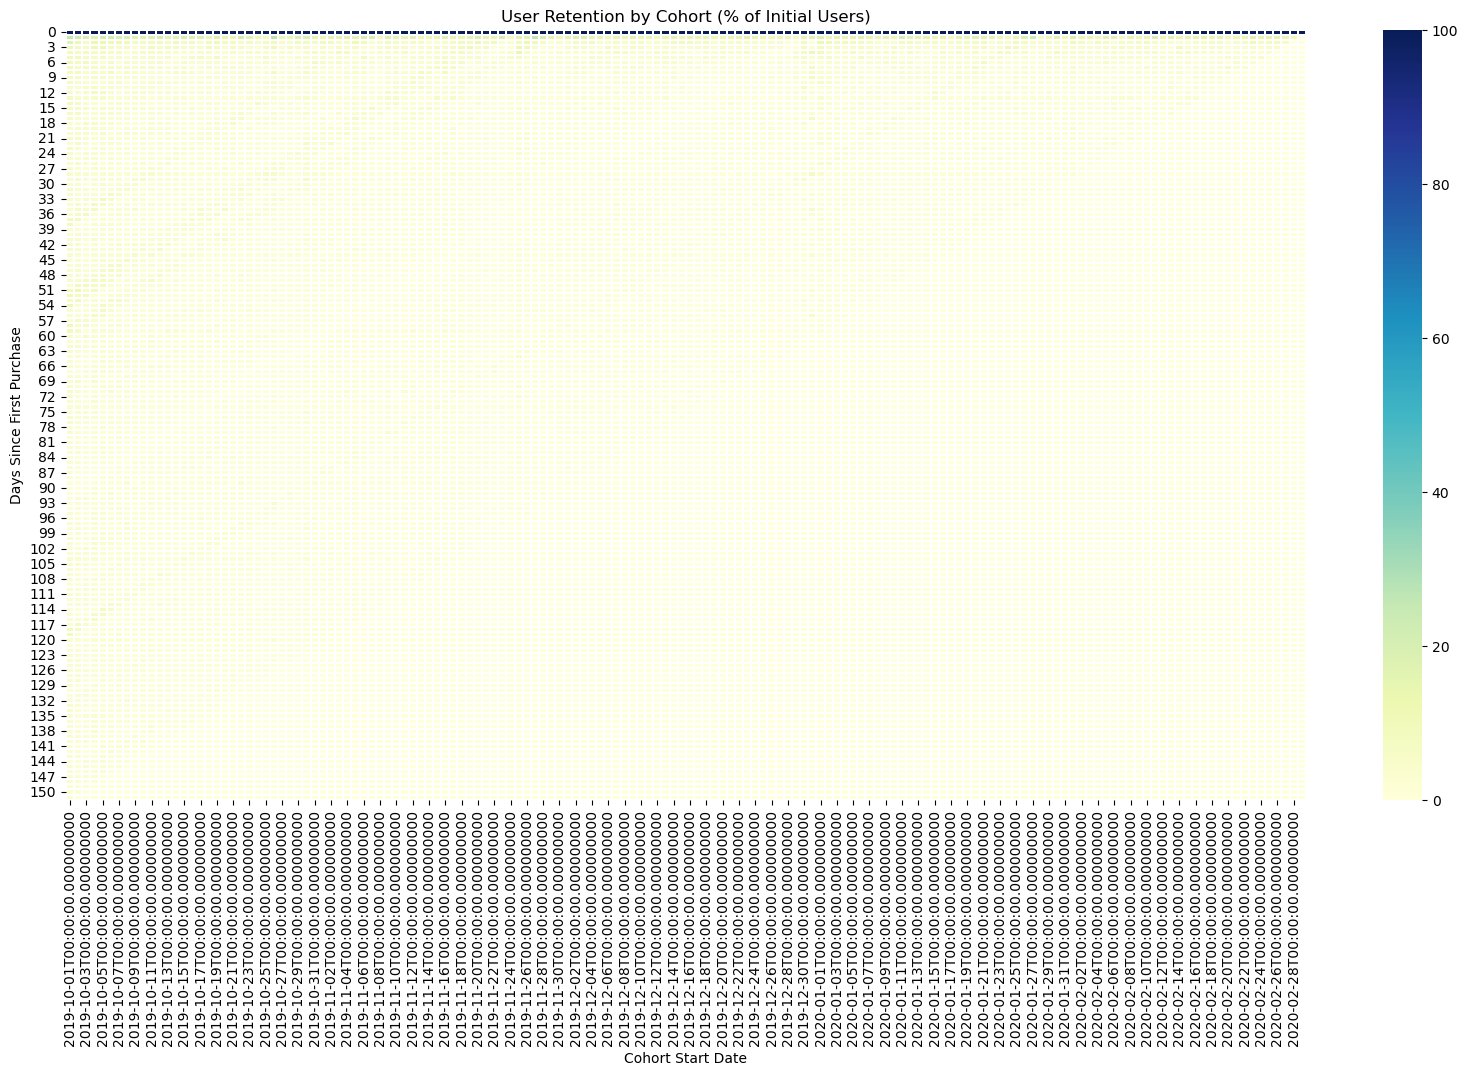

In [44]:
# Normalize cohort data to show % retention
cohort_pct = cohort_pivot.divide(cohort_pivot.iloc[0], axis=1) * 100

plt.figure(figsize=(20, 10))
sns.heatmap(cohort_pct, cmap='YlGnBu', annot=False, fmt='.0f', linewidths=0.3)
plt.title('User Retention by Cohort (% of Initial Users)')
plt.xlabel('Cohort Start Date')
plt.ylabel('Days Since First Purchase')
plt.show()

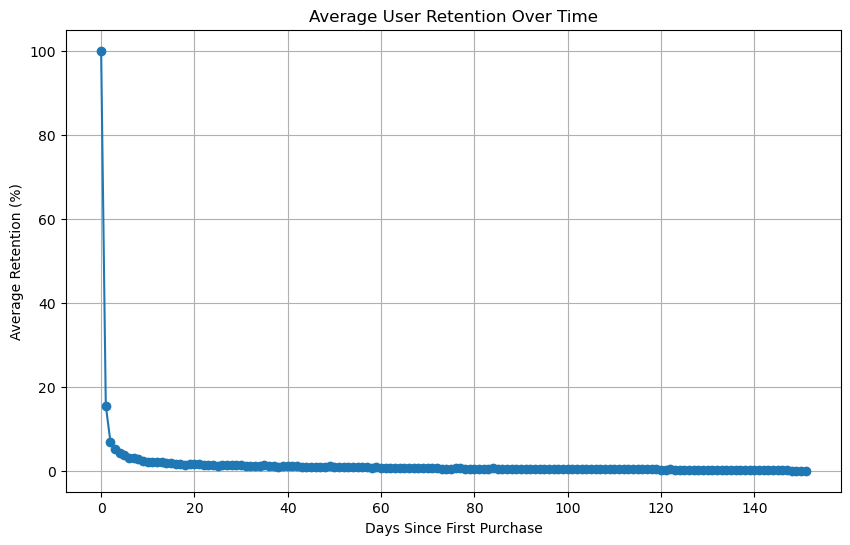

In [45]:
# Plot average retention across cohorts
avg_retention = cohort_pct.mean(axis=1)
plt.figure(figsize=(10,6))
plt.plot(avg_retention.index, avg_retention.values, marker='o')
plt.title('Average User Retention Over Time')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Average Retention (%)')
plt.grid(True)
plt.show()

In [42]:
# What categories/brands led to better retention/spending
first_purchases = (
    combined_df[combined_df['event_type'] == 'purchase']
    .sort_values(by='event_time')
    .drop_duplicates('user_id')
)
first_purchases

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,cohort_date_x,days_since_first,cohort_date_y
10674466,2019-10-01 00:06:35+00:00,purchase,5773207,1487580005134238553,NaN,runail,2.62,474232307,445f2b74-5e4c-427e-b7fa-6e0a28b156fe,2019-10-01,2019-10-01,0,2019-10-01
9970664,2019-10-01 00:10:30+00:00,purchase,5751383,1487580005092295511,NaN,uno,10.32,543446752,4a01cad9-7368-fd9e-d907-d4d85de0b55c,2019-10-01,2019-10-01,0,2019-10-01
13974501,2019-10-01 00:12:50+00:00,purchase,5857283,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01,2019-10-01,0,2019-10-01
13975801,2019-10-01 00:18:22+00:00,purchase,5864471,1597770225539875791,NaN,NaN,24.13,550021912,7698b35e-e2dc-486a-8f6e-4b148dbbbb15,2019-10-01,2019-10-01,0,2019-10-01
13975772,2019-10-01 00:19:17+00:00,purchase,5549772,1487580005595612013,NaN,NaN,3.00,250032160,d87285d5-0487-4cda-8328-0fb8b485a452,2019-10-01,2019-10-01,0,2019-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19197711,2020-02-29 22:59:30+00:00,purchase,5823277,1487580012096782476,NaN,runail,3.17,621665321,d63dd532-a0cb-e92c-567f-ca9843670856,2020-02-29,2020-02-28,1,2020-02-28
19201297,2020-02-29 23:02:10+00:00,purchase,5265,1487580010125459512,NaN,NaN,5.87,621716057,e34c2b57-6482-4721-a276-bc23144ccade,2020-02-29,2020-02-29,0,2020-02-29
19246059,2020-02-29 23:09:44+00:00,purchase,5846444,2151191071378375538,NaN,browxenna,19.52,590973950,aa5c076f-1b75-4bf6-b4ec-b4a14ecd3a86,2020-02-29,2020-02-29,0,2020-02-29
19081293,2020-02-29 23:46:01+00:00,purchase,5849997,1487580005595612013,NaN,NaN,3.00,620865261,64389dba-26c4-f328-6972-166a48654eaa,2020-02-29,2020-02-27,2,2020-02-27


In [29]:
# Find the first event date for each user
first_event = combined_df.groupby('user_id')['event_date'].min().reset_index()
first_event.columns = ['user_id', 'cohort_date']

In [31]:
# Merge cohort_date into main DataFrame
combined_df = combined_df.merge(first_event, on='user_id', how = 'left')

In [47]:
# Analyze category-wise conversion from view to purchase
category_conversion = combined_df[combined_df['event_type'].isin(['view', 'purchase'])]
category_counts = category_conversion.pivot_table(
    index='category_code',
    columns='event_type',
    values='user_id',
    aggfunc='nunique',
    fill_value=0
)
category_counts['conversion_rate'] = (category_counts['purchase'] / category_counts['view']) * 100
category_counts.sort_values('conversion_rate', ascending=False).head(10)

event_type,purchase,view,conversion_rate
category_code,,,
apparel.glove,3819,9646,39.591541
stationery.cartrige,2586,10124,25.543264
furniture.bathroom.bath,925,8049,11.492111
appliances.environment.vacuum,3192,33987,9.391826
appliances.environment.air_conditioner,31,336,9.226190
accessories.cosmetic_bag,110,1549,7.101356
appliances.personal.massager,35,1335,2.621723
appliances.personal.hair_cutter,55,2379,2.311896
furniture.living_room.cabinet,264,13378,1.973389


## 📈 Growth Insights Summary

- **Overall Conversion Rate**6.92f}% of users who viewed a product ended up purchasing.
- **Top Categories by Conversion**: Electronics and Smartphones showed the highest conversion from view to purchase.
- **Retention Trends**: Retention drops sharply after Day 1, suggesting low user stickiness.
- **Cohort Insight**: Users acquired in earlier months had slightly better Day 7 retention.

> **Next Step Recommendations:**
> - Introduce onboarding nudges for first-time users  
> - Investigate low-retention cohorts for UX friction  
> - Explore category-specific engagement campaigns